In [ ]:
# ======================================================
# Step 1: Setup (Mount Drive, Install packages)
# ======================================================
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision timm scikit-learn tqdm

# ======================================================
# Step 2: Unzip your dataset into /content/
# ======================================================
!rm -rf /content/DATA
!unzip -oq "/content/drive/MyDrive/LYProject/SkinCondition.zip" -d "/content/"

# Check dataset structure
!ls /content/DATA
!ls /content/DATA/train

Mounted at /content/drive
test  train  val
 acne   Eczema	 Psoriasis  'Tinea Ringworm'


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Epoch 1/5


/tmp/ipython-input-3842447159.py:83: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-3842447159.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.9031 Acc: 0.6235
Val Loss: 1.1558 Acc: 0.5314
Epoch 2/5
Train Loss: 0.7324 Acc: 0.6893
Val Loss: 0.7734 Acc: 0.6734
Epoch 3/5
Train Loss: 0.6541 Acc: 0.7194
Val Loss: 0.7794 Acc: 0.6481
Epoch 4/5
Train Loss: 0.6390 Acc: 0.7220
Val Loss: 0.8021 Acc: 0.6572
Epoch 5/5
Train Loss: 0.5741 Acc: 0.7546
Val Loss: 0.7524 Acc: 0.6744
Epoch 1/40
Train Loss: 0.5850 Acc: 0.7603
Val Loss: 0.5477 Acc: 0.7840
Epoch 2/40
Train Loss: 0.4197 Acc: 0.8313
Val Loss: 0.5199 Acc: 0.7941
Epoch 3/40
Train Loss: 0.3054 Acc: 0.8838
Val Loss: 0.5065 Acc: 0.8174
Epoch 4/40
Train Loss: 0.2458 Acc: 0.9036
Val Loss: 0.5388 Acc: 0.8215
Epoch 5/40
Train Loss: 0.1933 Acc: 0.9283
Val Loss: 0.4831 Acc: 0.8357
Epoch 6/40
Train Loss: 0.1505 Acc: 0.9464
Val Loss: 0.4884 Acc: 0.8418
Epoch 7/40
Train Loss: 0.1121 Acc: 0.9626
Val Loss: 0.4996 Acc: 0.8479
Epoch 8/40
Train Loss: 0.0931 Acc: 0.9683
Val Loss: 0.4723 Acc: 0.8489
Epoch 9/40
Train Loss: 0.0952 Acc: 0.9650
Val Loss: 0.4485 Acc: 0.8611
Epoch 10/40
Train Los

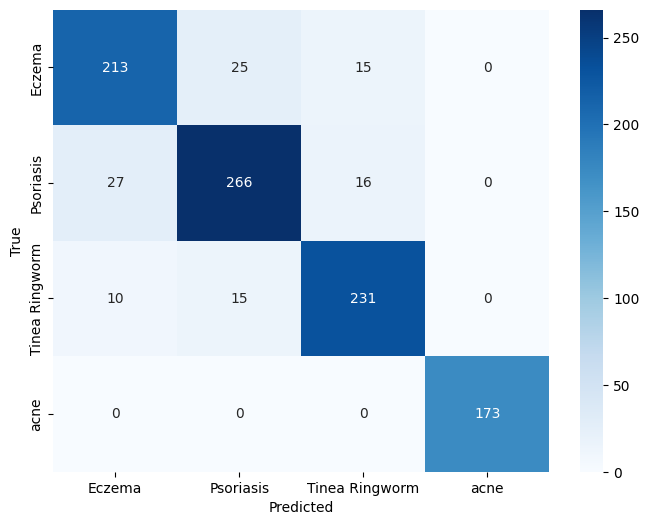

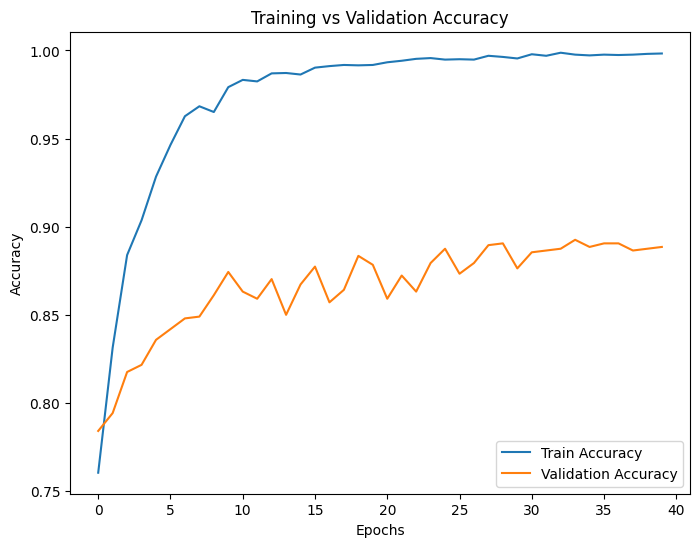

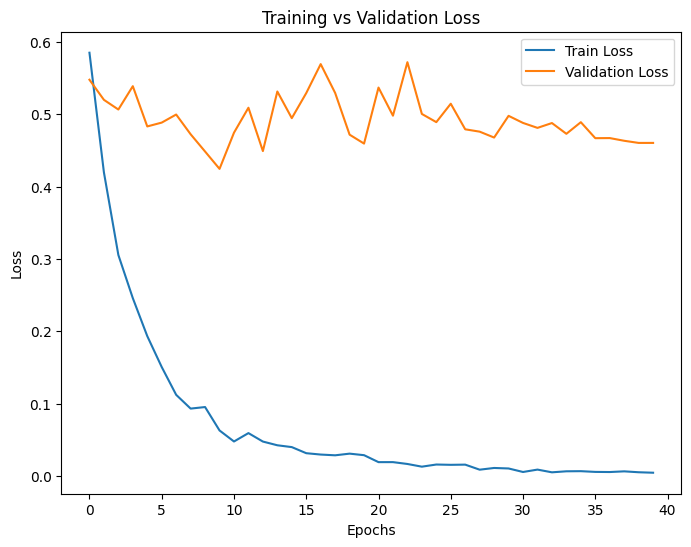

In [ ]:
# ======================================================
# Vision Transformer (ViT-B/16) for Skin Disease Classification
# ======================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
from tqdm import tqdm
import joblib
import h5py

# ======================================================
# Config
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/content/DATA"  # adjust to your dataset
batch_size = 16
num_epochs_head = 5
num_epochs_full = 40
lr_head = 1e-3
lr_full = 1e-5

# ======================================================
# Data Augmentation
# ======================================================
train_transforms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1)),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ======================================================
# Datasets & Loaders
# ======================================================
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transforms)

class_names = train_dataset.classes

# Balanced Sampler
class_counts = np.bincount([y for _, y in train_dataset.samples])
class_weights = 1. / class_counts
weights = [class_weights[y] for _, y in train_dataset.samples]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ======================================================
# Model: Vision Transformer (ViT-B/16)
# ======================================================
model = timm.create_model("vit_base_patch16_384", pretrained=True, num_classes=len(class_names))
model = model.to(device)

# ======================================================
# Training Function
# ======================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_acc, best_model_wts = 0.0, None
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Training
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc.item())

        # Validation
        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_corrects.double() / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()

    model.load_state_dict(best_model_wts)
    return model, history

# ======================================================
# Step 1: Train classifier head only
# ======================================================
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.head.parameters(), lr=lr_head)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs_head)

train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs_head)

# ======================================================
# Step 2: Fine-tune full model
# ======================================================
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=lr_full)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs_full)

model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs_full)

# ======================================================
# Test Evaluation
# ======================================================
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ======================================================
# Training Curves
# ======================================================
plt.figure(figsize=(8,6))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# ======================================================
# Save Model
# ======================================================
torch.save(model.state_dict(), "/content/drive/MyDrive/LYProject/vit_skin.pth")
joblib.dump(model, "/content/drive/MyDrive/LYProject/vit_skin.pkl")
with h5py.File("/content/drive/MyDrive/LYProject/vit_skin.h5", "w") as f:
    for key, val in model.state_dict().items():
        f.create_dataset(key, data=val.cpu().numpy())
